<a href="https://colab.research.google.com/github/dejunga/ML-Vehicle_Image_Classification/blob/main/WideResNet_model_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# **Load the dataset**

In [38]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Define the desired labels (airplane, automobile, ship, and truck)
classes_name = ['airplane', 'automobile', 'ship', 'truck']
desired_indices = [labels.index(label) for label in classes_name]

# Filter the training dataset to include only images with the desired labels
mask_train = np.isin(y_train, desired_indices).flatten()
X_train = X_train[mask_train]
y_train = y_train[mask_train]

# Filter the test dataset to include only images with the desired labels
mask_test = np.isin(y_test, desired_indices).flatten()
X_test = X_test[mask_test]
y_test = y_test[mask_test]

# Print the shapes of the filtered datasets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (20000, 32, 32, 3)
y_train shape: (20000, 1)
X_test shape: (4000, 32, 32, 3)
y_test shape: (4000, 1)


# **Data visualization**

<ipython-input-39-6a9508f2eb8f>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train[index])


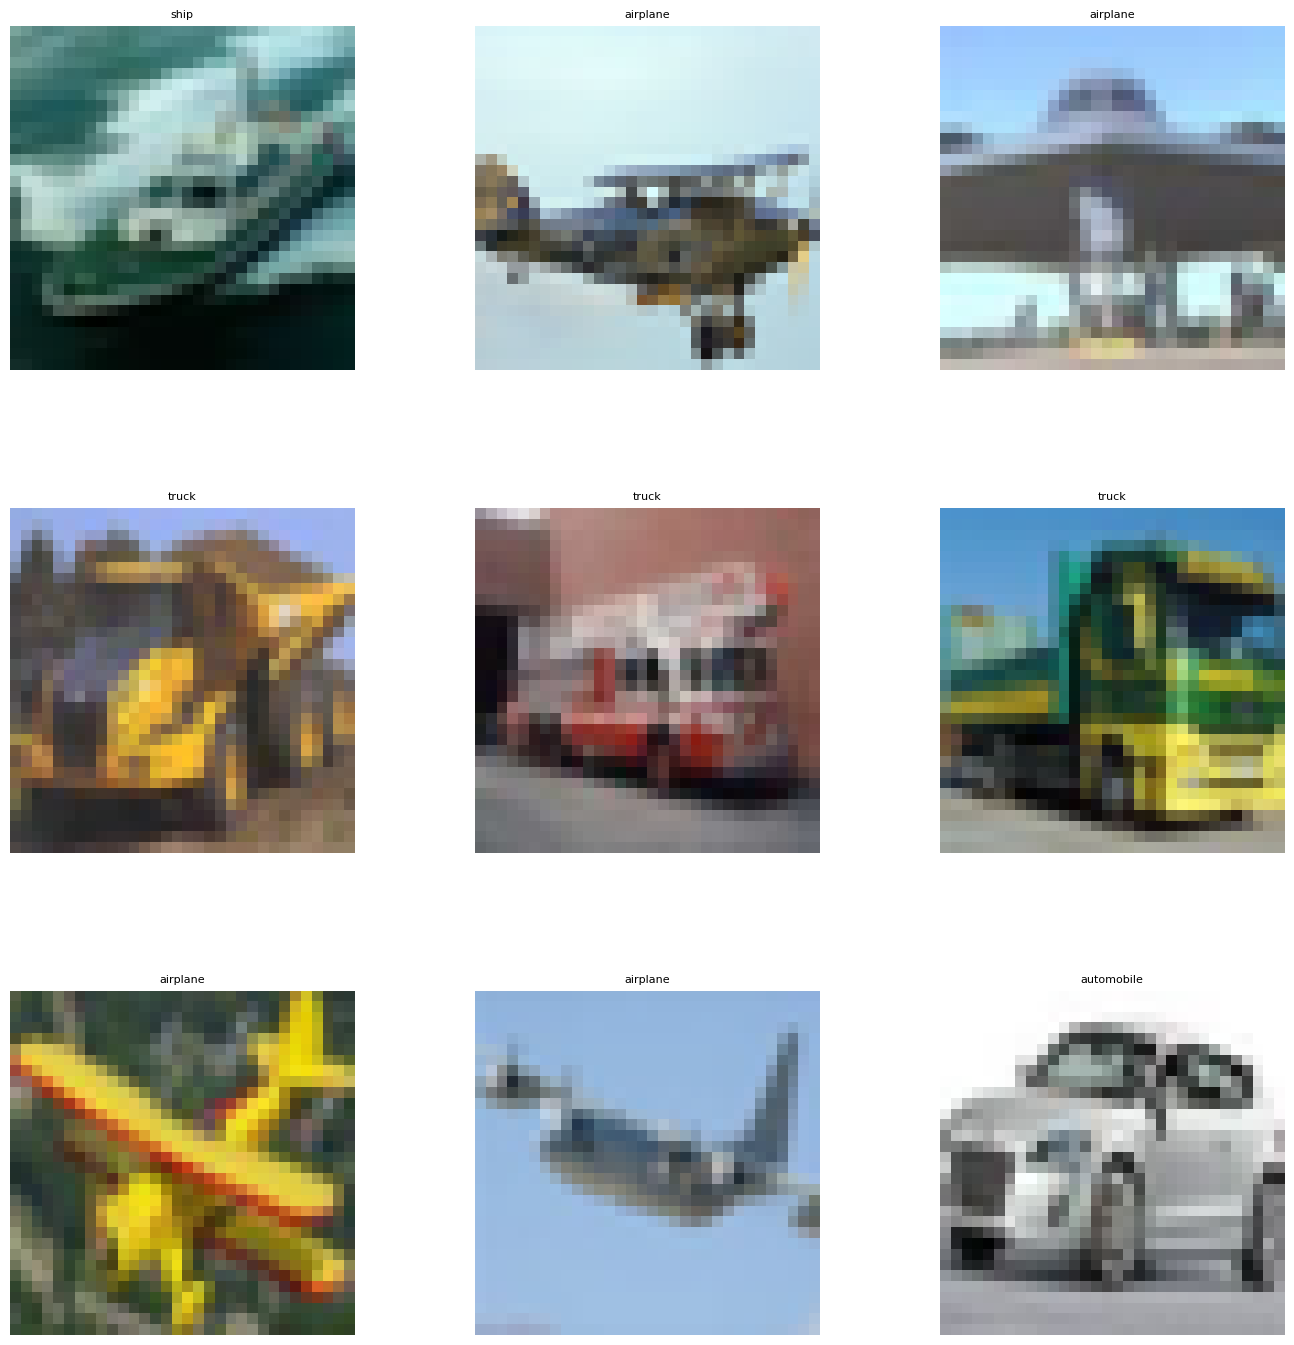

In [39]:
W_grid = 3
L_grid = 3

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel()  # Flatten the 10 x 10 matrix into 100 array

n_filtered = len(X_train)  # get the length of the filtered dataset

# Select a random number from 0 to n_filtered
for i in np.arange(0, W_grid * L_grid):  # create evenly spaced variables

    # Select a random number
    index = np.random.randint(0, n_filtered)
    # read and display an image with the selected index
    axes[i].imshow(X_train[index])

    # Get the corresponding label index
    label_index = int(y_train[index])

    # Display the corresponding label name
    axes[i].set_title(labels[label_index], fontsize=8)

    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)
plt.show()

# **Data preprocessing**

In [40]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [41]:
# number of classes
K = len(set(y_train.flatten())) # Flatten the array to get a 1D array of hashable values

# calculate total number of classes
# for output layer
print("number of classes:", K)

number of classes: 4


In [42]:
np.isnan(X_train).any()

False

In [47]:
np.isnan(X_test).any()

False

**WideResNet**

In [48]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import time

# Load ResNet50 pre-trained model without top layers, but with CIFAR-10 input shape
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Make a wider ResNet by increasing filter sizes
model_wide_resnet = Sequential(name="WideResNet")

# Add ResNet base
model_wide_resnet.add(resnet_base)

# Global Average Pooling
model_wide_resnet.add(GlobalAveragePooling2D())

# Dense layer with more neurons to make it "wider"
model_wide_resnet.add(Dense(512, activation='relu'))
model_wide_resnet.add(Dropout(0.5))

# Final softmax layer for CIFAR-10 classes
model_wide_resnet.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model_wide_resnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy',  metrics=METRICS)


# Data augmentation
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

# Track training time for ResNet50
start_time = time.time()

# Train the model
history_wide_resnet = model_wide_resnet.fit(train_generator,
                                            epochs=20,
                                            steps_per_epoch=steps_per_epoch,
                                            validation_data=(X_test, y_cat_test))

# End time
end_time = time.time()
training_time = end_time - start_time

# Log memory usage for GPU
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
memory_usage = None
if gpu_devices:
    memory_info = tf.config.experimental.get_memory_info('GPU:0')
    memory_usage = memory_info['peak'] / (1024 ** 2)

print(f"Training Time for ResNet: {training_time:.2f} seconds")
if memory_usage:
    print(f"Peak GPU Memory Usage for ResNet: {memory_usage:.2f} MB")

# Additional metrics like accuracy, precision, recall can be obtained from history_wide_resnet
final_accuracy = max(history_wide_resnet.history['accuracy'])
final_precision = max(history_wide_resnet.history['precision'])
final_recall = max(history_wide_resnet.history['recall'])

# Print the final results for the DenseNet model
print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final Precision: {final_precision:.4f}")
print(f"Final Recall: {final_recall:.4f}")

Epoch 1/20
625/625 [==============================] - 141s 198ms/step - loss: 1.2156 - accuracy: 0.5905 - precision: 0.6508 - recall: 0.5131 - val_loss: 3.9745 - val_accuracy: 0.2670 - val_precision: 0.2748 - val_recall: 0.2643
Epoch 2/20
625/625 [==============================] - 123s 196ms/step - loss: 0.6372 - accuracy: 0.7745 - precision: 0.8153 - recall: 0.7239 - val_loss: 0.4073 - val_accuracy: 0.8522 - val_precision: 0.8806 - val_recall: 0.8223
Epoch 3/20
625/625 [==============================] - 122s 195ms/step - loss: 0.4861 - accuracy: 0.8253 - precision: 0.8556 - recall: 0.7910 - val_loss: 0.3726 - val_accuracy: 0.8652 - val_precision: 0.8857 - val_recall: 0.8405
Epoch 4/20
625/625 [==============================] - 122s 195ms/step - loss: 0.3965 - accuracy: 0.8582 - precision: 0.8814 - recall: 0.8335 - val_loss: 0.3216 - val_accuracy: 0.8860 - val_precision: 0.9002 - val_recall: 0.8660
Epoch 5/20
625/625 [==============================] - 122s 195ms/step - loss: 0.3606 - a

# **Model Evaluation**

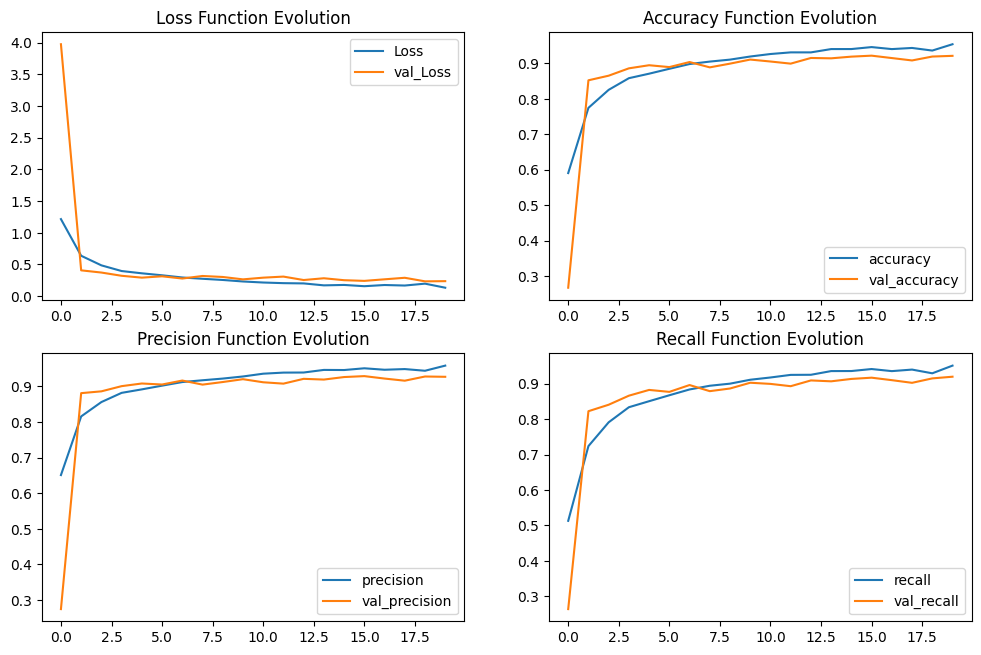

In [49]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history_wide_resnet.history['loss'], label='Loss')
plt.plot(history_wide_resnet.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_wide_resnet.history['accuracy'], label='accuracy')
plt.plot(history_wide_resnet.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_wide_resnet.history['precision'], label='precision')
plt.plot(history_wide_resnet.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history_wide_resnet.history['recall'], label='recall')
plt.plot(history_wide_resnet.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

125/125 [==============================] - 6s 50ms/step - loss: 0.2368 - accuracy: 0.9212 - precision: 0.9264 - recall: 0.9195
Test Accuracy : 92.12%
125/125 [==============================] - 7s 49ms/step


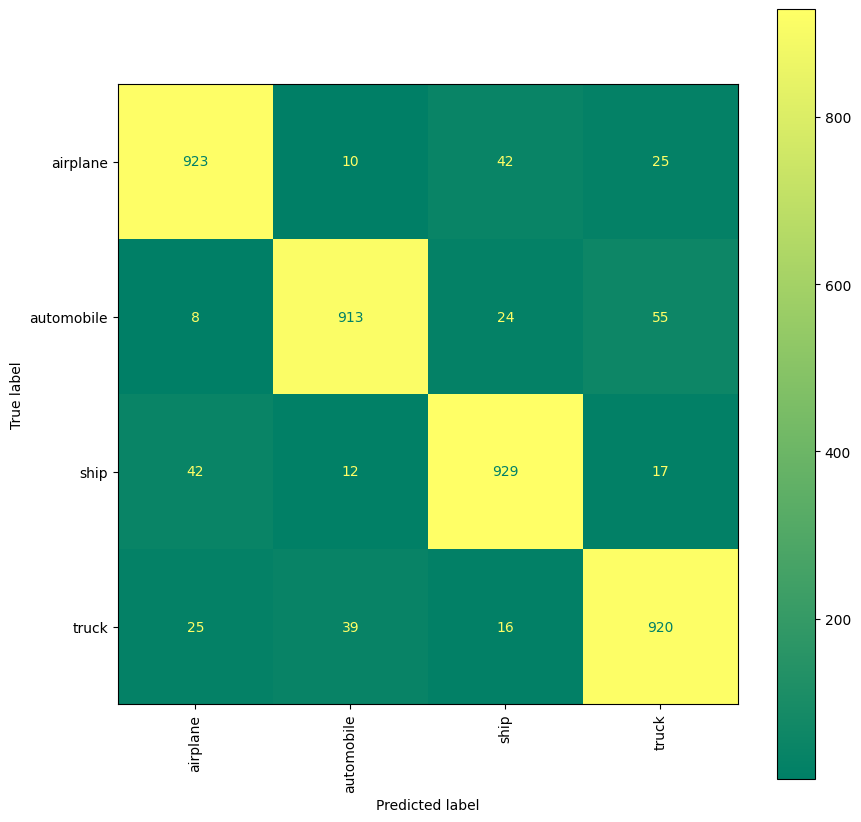

In [50]:
evaluation = model_wide_resnet.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model_wide_resnet.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_name)

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

125/125 [==============================] - 6s 49ms/step


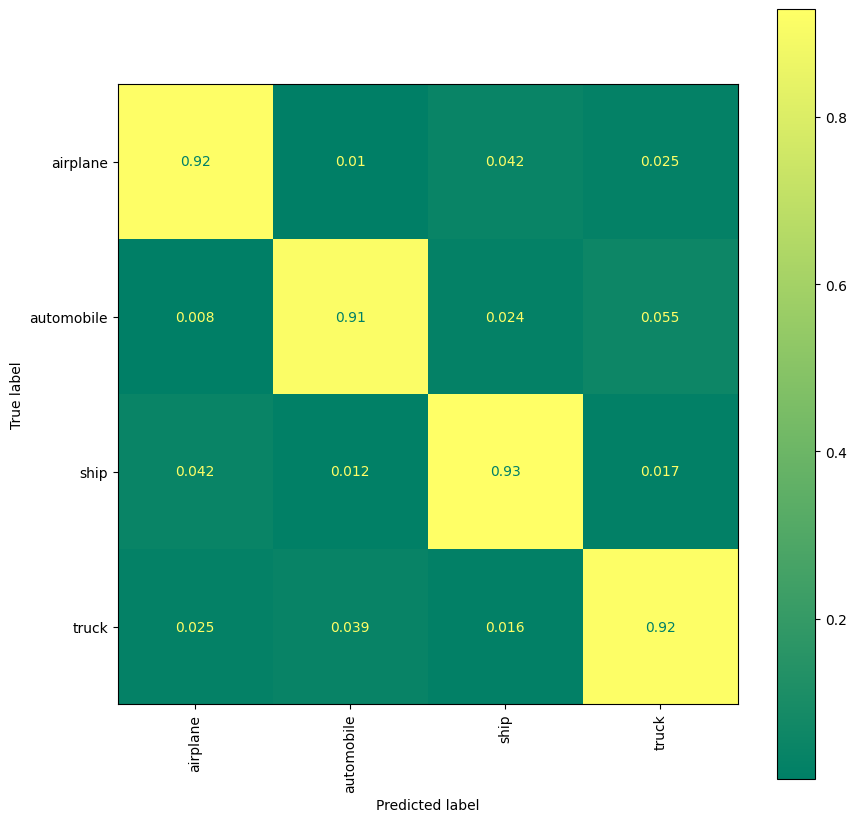

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model and print the test accuracy
evaluation = model_wide_resnet.evaluate(X_test, y_cat_test)
y_pred = model_wide_resnet.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

# Display the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classes_name)

# Plot the confusion matrix with values between 0 and 1
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

plt.show()

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1000
           1       0.94      0.91      0.93      1000
           8       0.92      0.93      0.92      1000
           9       0.90      0.92      0.91      1000

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000

